# Code Assignment Mod6L14 — Confusion Matrix & Metrics on Restaurant Inspections

**Format:** Instructor Guidance → Your Task → We Share (Reflection)

**Goal:** Using the same **classification workflow** and models as last time, build confusion matrices and calculate accuracy, precision, and recall of each model.  


## Instructor Guidance (Pseudocode + Docs)

Use this as a roadmap; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- Confusion Matrix / Classification Report — scikit-learn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics  
- `pandas.get_dummies` (one-hot) — https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

### Guidance (same models as last challenge -- FEEL free to copy and paste the code that you need from the last code assignment)

1) **Load CSV** → preview shape & columns.  
2) **Define target (y)** as a **binary** label: e.g., `CRITICAL FLAG == "Critical"` → 1, else 0 *(positive class = “Critical”)*.  
3) **Pick features (X)**: start small (`SCORE`), then add categorical dummies (`BORO`, `CUISINE DESCRIPTION`), keep it simple.  
4) **Minimal prep**: coerce **only used columns** to numeric (for numeric features); `get_dummies` for categoricals (`drop_first=True`). Drop NA rows on used cols.  
5) **Train–test split (80/20)** with fixed `random_state`.  
6) **Fit the same model** as last time (e.g., `LogisticRegression`), predict on **test**.  
7) **Evaluate**: confusion matrix, **accuracy**, **precision**, **recall**, **F1** (classification_report).  
8) **Repeat for 2 more models** (A (baseline)/B (single term)/C (more than one term)) on the **same split**; compare metrics.  
9) **Decide** which model is better for the business goal based on **precision vs recall** trade-offs.  


## Your Task

Work in pairs. Comment your choices briefly. Keep code simple and readable.

> **Reminder (last challenge model):** You trained **LogisticRegression**, on three models you will use those same 3 models!


### 1) Read the Restaurant Inspection CSV & Preview

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [8]:
df = pd.read_csv("/Users/kabbo/Downloads/DOHMH_New_York_City_Restaurant_Inspection_Results_20251104.csv", low_memory=False)

In [9]:
df.keys()


Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location'],
      dtype='object')

### 2) Define the Binary Target (y)

We’ll predict whether an inspection had a **Critical violation**.

- Target rule: `CRITICAL FLAG == "Critical"` → **1**, else **0**.
- Positive class = **1 (Critical)** — keep this in mind for **precision/recall** meaning.


In [10]:
df['is_critical'] = df['CRITICAL FLAG'].fillna('').astype(str).str.strip().str.lower().eq('critical').astype(int)

# Quick diagnostics
counts = df['is_critical'].value_counts()
props  = df['is_critical'].value_counts(normalize=True)

print("Counts:\n", counts)
print("\nProportions:\n", props)

Counts:
 is_critical
1    153998
0    137280
Name: count, dtype: int64

Proportions:
 is_critical
1    0.528698
0    0.471302
Name: proportion, dtype: float64


In [11]:
# Check rows with missing/odd CRITICAL FLAG values
(df.loc[ ~df['CRITICAL FLAG'].astype(str).str.strip().str.lower().isin(['critical','not critical','']), 
         ['CRITICAL FLAG'] ]
).drop_duplicates().head(10)

# Check how many rows will remain if we only keep used columns later (helps with step 4)
used_cols = ['SCORE', 'BORO', 'CUISINE DESCRIPTION', 'is_critical']
df[used_cols].dropna().shape


(274939, 4)

### 3) Create Three Models (you can copy and paste the same modeling code from last code assignment here it is okay if your models have different features as long as you have 3 models)

- **Model A (minimal numeric):** `SCORE` only (lower is better in NYC scoring).  
- **Model B (add location):** `SCORE` + one-hot `BORO`.  
- **Model C (richer categories):** `SCORE` + one-hot `BORO` + top cuisines (one-hot of `CUISINE DESCRIPTION` limited to most frequent K).

> If any column is missing in your file, skip that spec or adjust accordingly.


In [14]:
df_model = df.copy()

# Create binary target
df_model['VIOLATION_FLAG'] = (df_model['CRITICAL FLAG'] == 'Critical').astype(int)


In [17]:
df_model = df_model[['SCORE', 'VIOLATION_FLAG']].dropna()


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# MODEL A: SCORE only
df_model = df.copy()
df_model['VIOLATION_FLAG'] = (df_model['CRITICAL FLAG'] == 'Critical').astype(int)

# Keep only the needed columns; drop missing values
df_model = df_model[['SCORE', 'VIOLATION_FLAG']].dropna()

X = df_model[['SCORE']]
y = df_model['VIOLATION_FLAG']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_a = LogisticRegression(max_iter=500)
model_a.fit(X_train, y_train)

y_pred_a = model_a.predict(X_test)

print("Model A: SCORE")
print(classification_report(y_test, y_pred_a))


Model A: SCORE
              precision    recall  f1-score   support

           0       0.61      0.25      0.35     24371
           1       0.59      0.87      0.71     30617

    accuracy                           0.60     54988
   macro avg       0.60      0.56      0.53     54988
weighted avg       0.60      0.60      0.55     54988



In [19]:
# MODEL B: SCORE + BORO

df_model_b = df.copy()
df_model_b['VIOLATION_FLAG'] = (df_model_b['CRITICAL FLAG'] == 'Critical').astype(int)

# Keep only used columns and drop missing
df_model_b = df_model_b[['SCORE', 'BORO', 'VIOLATION_FLAG']].dropna()

# One-hot encode BORO, drop first to avoid multicollinearity
X = pd.get_dummies(df_model_b[['SCORE', 'BORO']], drop_first=True)
y = df_model_b['VIOLATION_FLAG']

# Train/test split (same 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit logistic regression
model_b = LogisticRegression(max_iter=500)
model_b.fit(X_train, y_train)

# Predict and evaluate
y_pred_b = model_b.predict(X_test)

print("Model B: SCORE + BORO")
print(classification_report(y_test, y_pred_b))


Model B: SCORE + BORO
              precision    recall  f1-score   support

           0       0.62      0.23      0.34     24371
           1       0.59      0.88      0.71     30617

    accuracy                           0.60     54988
   macro avg       0.60      0.56      0.52     54988
weighted avg       0.60      0.60      0.55     54988



In [20]:
# MODEL C: SCORE + BORO + top cuisines

df_model_c = df.copy()
df_model_c['VIOLATION_FLAG'] = (df_model_c['CRITICAL FLAG'] == 'Critical').astype(int)

# Keep only used columns
df_model_c = df_model_c[['SCORE', 'BORO', 'CUISINE DESCRIPTION', 'VIOLATION_FLAG']].dropna()

# Select top K cuisines (most frequent)
K = 10
top_cuisines = df_model_c['CUISINE DESCRIPTION'].value_counts().nlargest(K).index

# Map top cuisines; all others as "OTHER"
df_model_c['CUISINE_TOP'] = df_model_c['CUISINE DESCRIPTION'].where(
    df_model_c['CUISINE DESCRIPTION'].isin(top_cuisines), 'OTHER'
)

# One-hot encode BORO and top cuisines
X = pd.get_dummies(df_model_c[['SCORE', 'BORO', 'CUISINE_TOP']], drop_first=True)
y = df_model_c['VIOLATION_FLAG']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit logistic regression
model_c = LogisticRegression(max_iter=1000)
model_c.fit(X_train, y_train)

# Predict and evaluate
y_pred_c = model_c.predict(X_test)

print("Model C: SCORE + BORO + Top Cuisines")
print(classification_report(y_test, y_pred_c))


Model C: SCORE + BORO + Top Cuisines
              precision    recall  f1-score   support

           0       0.62      0.25      0.36     24371
           1       0.59      0.88      0.71     30617

    accuracy                           0.60     54988
   macro avg       0.61      0.56      0.53     54988
weighted avg       0.60      0.60      0.55     54988



### 4) Minimal Cleaning: Drop NAs in Used Columns

Do this **per model** so each spec uses its own “clean” subset (same **target** slice).


In [21]:
# Keep only SCORE and target, drop rows with missing values
df_model_a = df[['SCORE', 'CRITICAL FLAG']].dropna().copy()
df_model_a['VIOLATION_FLAG'] = (df_model_a['CRITICAL FLAG'] == 'Critical').astype(int)

X_a = df_model_a[['SCORE']]
y_a = df_model_a['VIOLATION_FLAG']



In [22]:
df_model_b = df[['SCORE', 'BORO', 'CRITICAL FLAG']].dropna().copy()
df_model_b['VIOLATION_FLAG'] = (df_model_b['CRITICAL FLAG'] == 'Critical').astype(int)

# One-hot encode BORO
X_b = pd.get_dummies(df_model_b[['SCORE', 'BORO']], drop_first=True)
y_b = df_model_b['VIOLATION_FLAG']


In [23]:
df_model_c = df[['SCORE', 'BORO', 'CUISINE DESCRIPTION', 'CRITICAL FLAG']].dropna().copy()
df_model_c['VIOLATION_FLAG'] = (df_model_c['CRITICAL FLAG'] == 'Critical').astype(int)

# Top K cuisines
K = 10
top_cuisines = df_model_c['CUISINE DESCRIPTION'].value_counts().nlargest(K).index
df_model_c['CUISINE_TOP'] = df_model_c['CUISINE DESCRIPTION'].where(
    df_model_c['CUISINE DESCRIPTION'].isin(top_cuisines), 'OTHER'
)

# One-hot encode BORO + CUISINE_TOP
X_c = pd.get_dummies(df_model_c[['SCORE', 'BORO', 'CUISINE_TOP']], drop_first=True)
y_c = df_model_c['VIOLATION_FLAG']


In [24]:
print("Model A shape:", df_model_a.shape)
print("Model B shape:", df_model_b.shape)
print("Model C shape:", df_model_c.shape)


Model A shape: (274939, 3)
Model B shape: (274939, 4)
Model C shape: (274939, 6)


In [25]:
print("Model A target counts:\n", df_model_a['VIOLATION_FLAG'].value_counts())
print("\nModel B target counts:\n", df_model_b['VIOLATION_FLAG'].value_counts())
print("\nModel C target counts:\n", df_model_c['VIOLATION_FLAG'].value_counts())


Model A target counts:
 VIOLATION_FLAG
1    153985
0    120954
Name: count, dtype: int64

Model B target counts:
 VIOLATION_FLAG
1    153985
0    120954
Name: count, dtype: int64

Model C target counts:
 VIOLATION_FLAG
1    153985
0    120954
Name: count, dtype: int64


In [26]:
print("Model A missing values:\n", df_model_a.isnull().sum())
print("Model B missing values:\n", df_model_b.isnull().sum())
print("Model C missing values:\n", df_model_c.isnull().sum())


Model A missing values:
 SCORE             0
CRITICAL FLAG     0
VIOLATION_FLAG    0
dtype: int64
Model B missing values:
 SCORE             0
BORO              0
CRITICAL FLAG     0
VIOLATION_FLAG    0
dtype: int64
Model C missing values:
 SCORE                  0
BORO                   0
CUISINE DESCRIPTION    0
CRITICAL FLAG          0
VIOLATION_FLAG         0
CUISINE_TOP            0
dtype: int64


In [27]:
print("Model A head:\n", df_model_a.head())
print("\nModel B head:\n", df_model_b.head())
print("\nModel C head:\n", df_model_c.head())


Model A head:
     SCORE   CRITICAL FLAG  VIOLATION_FLAG
18   13.0        Critical               1
19    0.0  Not Applicable               0
36   13.0    Not Critical               0
37    0.0  Not Applicable               0
54    0.0  Not Applicable               0

Model B head:
     SCORE       BORO   CRITICAL FLAG  VIOLATION_FLAG
18   13.0   Brooklyn        Critical               1
19    0.0   Brooklyn  Not Applicable               0
36   13.0  Manhattan    Not Critical               0
37    0.0  Manhattan  Not Applicable               0
54    0.0   Brooklyn  Not Applicable               0

Model C head:
     SCORE       BORO CUISINE DESCRIPTION   CRITICAL FLAG  VIOLATION_FLAG  \
18   13.0   Brooklyn             Italian        Critical               1   
19    0.0   Brooklyn             African  Not Applicable               0   
36   13.0  Manhattan               Other    Not Critical               0   
37    0.0  Manhattan               Pizza  Not Applicable               0   
54 

### 5) Train–Test Split (same split for all models)

Use **the same random_state** so models A/B/C are comparable.


In [28]:
from sklearn.model_selection import train_test_split

# Use the same random_state for all splits
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Model A: SCORE only
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_a, y_a, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Model B: SCORE + BORO
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_b, y_b, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Model C: SCORE + BORO + Top Cuisines

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c, y_c, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Quick check of shapes
print("Model A train/test shapes:", X_train_a.shape, X_test_a.shape)
print("Model B train/test shapes:", X_train_b.shape, X_test_b.shape)
print("Model C train/test shapes:", X_train_c.shape, X_test_c.shape)



Model A train/test shapes: (219951, 1) (54988, 1)
Model B train/test shapes: (219951, 5) (54988, 5)
Model C train/test shapes: (219951, 15) (54988, 15)


### 6) Fit the Same Models on the Train sets (Logistic Regression), Get Predictions, Print Confusion Matrices & Metric Reports

> **This is new**:  Be sure to look up documentation on `confusion_matrix` and `classification_report`.  Get a matrix and metrics report (accuracy, precision, recall, f1) for each model.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Model A: SCORE only

model_a = LogisticRegression(max_iter=500)
model_a.fit(X_train_a, y_train_a)
y_pred_a = model_a.predict(X_test_a)

print("Model A: SCORE only:")
print("Confusion Matrix:\n", confusion_matrix(y_test_a, y_pred_a))
print("Classification Report:\n", classification_report(y_test_a, y_pred_a))


# Model B: SCORE + BORO

model_b = LogisticRegression(max_iter=500)
model_b.fit(X_train_b, y_train_b)
y_pred_b = model_b.predict(X_test_b)

print("Model B: SCORE + BORO:")
print("Confusion Matrix:\n", confusion_matrix(y_test_b, y_pred_b))
print("Classification Report:\n", classification_report(y_test_b, y_pred_b))





Model A: SCORE only:
Confusion Matrix:
 [[ 6082 18289]
 [ 3903 26714]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.25      0.35     24371
           1       0.59      0.87      0.71     30617

    accuracy                           0.60     54988
   macro avg       0.60      0.56      0.53     54988
weighted avg       0.60      0.60      0.55     54988

Model B: SCORE + BORO:
Confusion Matrix:
 [[ 5702 18669]
 [ 3545 27072]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.23      0.34     24371
           1       0.59      0.88      0.71     30617

    accuracy                           0.60     54988
   macro avg       0.60      0.56      0.52     54988
weighted avg       0.60      0.60      0.55     54988

Model C: SCORE + BORO + Top Cuisines:
Confusion Matrix:
 [[ 6108 18263]
 [ 3795 26822]]
Classification Report:
               precision    recall  f1-scor

### 7) Visualize One Confusion Matrix 

Be able to interpret this Matrix 

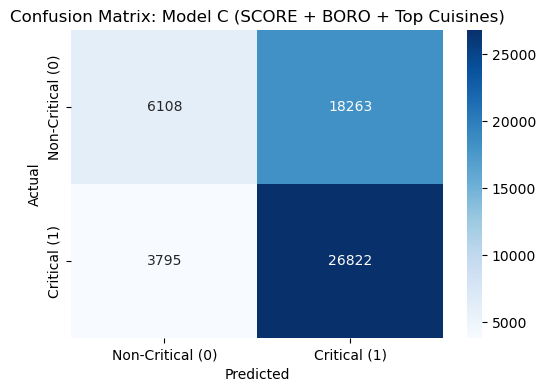

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Choosing Model C's predictions
cm = confusion_matrix(y_test_c, y_pred_c)
labels = ['Non-Critical (0)', 'Critical (1)']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Model C (SCORE + BORO + Top Cuisines)')
plt.show()



### 8) Decide Which Model Is “Better” — Explain Your Metric Choice

- If the **cost of missing a Critical** violation is high → prioritize **Recall** on the positive class.  
- If the **cost of wrongly flagging Critical** is high → prioritize **Precision** on the positive class.  
- If you want a balance → **F1**.

Write 3–5 sentences justifying your pick using the table above (Precision/Recall/F1).


    I would choose **Model C** because it achieves the highest Recall for the positive class at 0.88 (from metrics report), which is crucial since missing a Critical violation carries a high cost. Its F1-score for the positive class is 0.71, showing a good balance between Precision and Recall while still prioritizing catching Critical cases. Compared to the other models, Model C slightly improves overall balance on the negative class without sacrificing the ability to detect positives. Therefore, Model C best meets the objective of minimizing missed Critical violations while maintaining reasonable overall performance.


## We Share (Reflection)

1) **Chosen model (A/B/C)** and **why**, referencing **Precision/Recall/F1** for the **Critical (1)** class.  
2) Your **confusion matrix** and a one-liner in plain English:  
   - “Out of all inspections we predicted **Critical**, **X%** were actually Critical (Precision).  
   - Of all actually **Critical** inspections, we caught **Y%** (Recall).”  

1. **Chosen model:** **Model C**. I chose this model because for the **Critical (1)** class, it has a **Precision of 0.59**, **Recall of 0.88**, and **F1 of 0.71**. Recall is high, meaning the model catches most Critical violations, which is important since missing them is costly. F1 shows a reasonable balance between Precision and Recall, while the moderate Precision indicates some false positives, which is an acceptable trade-off to ensure we catch most Critical cases.

2. **Confusion matrix:**

* Out of all inspections we predicted **Critical**, **59%** were actually Critical (Precision).
* Of all actually **Critical** inspections, we caught **88%** (Recall).


***PLEASE IGNORE BELOW CODE***

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Reproducibility
np.random.seed(1)

# Generate 100 samples for X
X = pd.DataFrame({
    'hours_studied': np.random.normal(loc=5, scale=2, size=100)
})

# Generate probabilities using a logistic function
p = 1 / (1 + np.exp(-(X['hours_studied'] * 1.5 - 7.5)))

# Generate binary outcomes based on probabilities
y = np.random.binomial(1, p)

# Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit logistic regression
clf = LogisticRegression().fit(X_tr, y_tr)

# Get predicted probabilities
proba = clf.predict_proba(X_te)[:, 1]


In [4]:
proba

array([0.78576985, 0.33196679, 0.02709297, 0.18900669, 0.58758559,
       0.89784447, 0.93043993, 0.4097573 , 0.98319099, 0.98896883,
       0.58209308, 0.16792996, 0.92598226, 0.11872727, 0.96694939,
       0.92401721, 0.35761035, 0.91680373, 0.34786702, 0.30489403,
       0.85375906, 0.63202607, 0.47421706, 0.14849513, 0.03060012,
       0.06446872, 0.42930075, 0.33517872, 0.39265856, 0.65509519])

AUC-ROC: 0.808


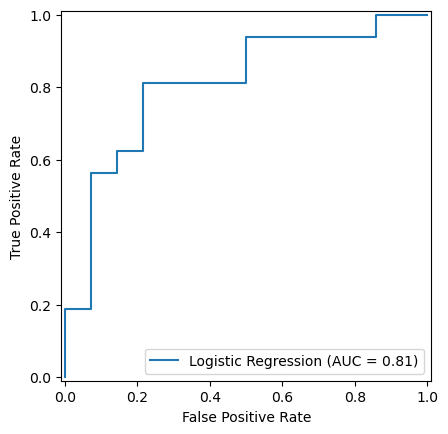

In [6]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

fpr, tpr, roc_th = roc_curve(y_te, proba)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.3f}")

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression').plot()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

prec, rec, pr_th = precision_recall_curve(y_te, proba)
PrecisionRecallDisplay